In [19]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


First we need data.

We'll be making our own data for this project that has an obvious statistical correlation.

Run the code below, but don't worry about how it works.

In [9]:
np.random.seed(42)
stocks = ['ALP', 'BRV', 'CRX']
dates = pd.bdate_range(start="2024-01-01", end="2024-06-30") 

data = []

for stock in stocks:
    base_price = np.random.uniform(50, 200)
    price = base_price
    for date in dates:
        sentiment = np.random.normal(0, 0.3)
        volatility = np.clip(np.random.normal(0.02, 0.01), 0.005, 0.05)
        volume = int(np.random.normal(1_000_000, 200_000) * (1 + volatility * 10))
        daily_return = np.random.normal(0.0005, 0.01) + 0.002 * sentiment
        open_price = price
        high_price = open_price * (1 + volatility * np.random.uniform(0.5, 1.2))
        low_price = open_price * (1 - volatility * np.random.uniform(0.5, 1.2))
        close_price = open_price * (1 + daily_return)

        price = close_price

        data.append({
            "Date": date,
            "Stock": stock,
            "Open": round(open_price, 2),
            "High": round(high_price, 2),
            "Low": round(low_price, 2),
            "Close": round(close_price, 2),
            "Volume": volume,
            "Volatility": round(volatility, 4),
            "Sentiment": round(sentiment, 3),
            "Return": round(daily_return, 4),
        })

df = pd.DataFrame(data)

df.to_csv("data.csv", index=False)


First, we'll explore the shape and description of our data

In [ ]:
df = pd.read_csv('data.csv')
df.head()
## Explore the data further:
    # Check for column names:
        #df.columns
    # Check for missing values:
        #df.isnull().sum()
    # Check for duplicates
        #df.duplicated().sum()
    # Check for outliers
        #df.describe()
    # Check for data types
        #df.dtypes
    # Check for data distribution
        #sns.histplot(df['column_name'])
    # Check for data correlation
        #sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
    # Check for data relationship
        #sns.pairplot(df)

Now, lets plot our stock data to grasp a better understanding

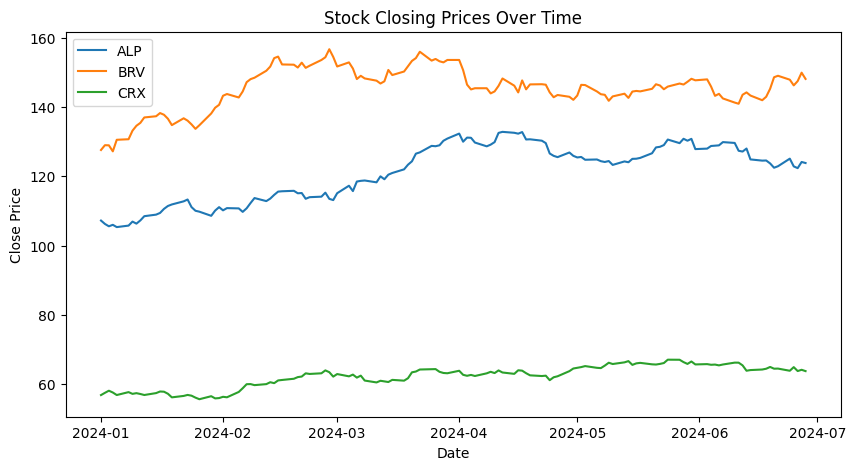

In [15]:
plt.figure(figsize=(10,5))
for stock in df["Stock"].unique():
    subset = df[df["Stock"] == stock]
    plt.plot(subset["Date"], subset["Close"], label=stock)
plt.title("Stock Closing Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

In time series data, it is often reasonable to assume that recent events are indicitive of future events. 

However, this relationship is often not linear, as our data is currently stored as. A better relationship is often achieved by taking the log of our data, placing fleating emphasis on data.

Lets create new columns in our data for the Daily Return and Log Return of each equity

In [ ]:
df["Daily_Return"] = df.groupby("Stock")["Close"].pct_change()
df["Log_Return"] = np.log1p(df["Daily_Return"])
print(df.head(10))


--- Return Calculation Example ---
        Date Stock    Open    High     Low   Close   Volume  Volatility  \
0 2024-01-01   ALP  106.18  108.63  104.91  107.24  1300639      0.0232   
1 2024-01-02   ALP  107.24  108.61  105.97  106.26  1016353      0.0147   
2 2024-01-03   ALP  106.26  106.66  105.83  105.58   960110      0.0050   
3 2024-01-04   ALP  105.58  107.04  103.04  106.01  1904646      0.0260   
4 2024-01-05   ALP  106.01  108.53  104.18  105.35  1370106      0.0295   
5 2024-01-08   ALP  105.35  107.37  103.84  105.78  1144404      0.0199   
6 2024-01-09   ALP  105.78  109.65  103.88  106.94  1377056      0.0319   
7 2024-01-10   ALP  106.94  107.34  106.57  106.35  1212477      0.0050   
8 2024-01-11   ALP  106.35  108.65  103.99  107.28  1354717      0.0213   
9 2024-01-12   ALP  107.28  108.08  106.22  108.50   794501      0.0138   

   Sentiment  Return  Daily_Return  Log_Return  
0     -0.334  0.0099           NaN         NaN  
1     -0.174 -0.0091     -0.009138   -0.

Note, the first column of our data has NaN values in both of the new columns. If we try to fit a model with the current data we'll run into an error.

There are a couple of options that we can chose from each with different cost-benefits the choice falls onto the analyst to choose from.

1. Drop the NaN rows entirely

    Pros: Simple and ensures the model only sees valid numeric data.

    Cons: You lose information — potentially valuable observations, especially if missing data is systematic (e.g., at the start of a time series).

    When to use: When only a few rows are missing or when time continuity is not essential.

2. Forward-fill or backward-fill missing values (ffill / bfill)

    Pros: Maintains dataset size and continuity (important for time series).

    Cons: May introduce bias if the previous (or next) value doesn’t represent the current trend.

    When to use: When consecutive observations are strongly correlated, as in stock price data.

3. Impute missing values statistically (e.g., mean, median, regression, or model-based imputation)

    Pros: Keeps all data, can reduce bias from naive filling.

    Cons: Adds modeling assumptions and complexity; may distort variance.

    When to use: When data loss is costly and missingness is not random.

4. Treat NaNs as meaningful

    Pros: Sometimes, the absence of data is itself informative (e.g., zero volume days, halted trading).

    Cons: Only applicable if the missingness conveys signal rather than error.

    When to use: In feature engineering, where “missing” has real-world significance.


In [24]:
## We'll forward fill our data for sake on continuity
df = df.groupby("Stock").apply(lambda x: x.ffill().bfill()).reset_index(drop=True)
df.head(10)

/var/folders/zy/_gdrv51j3lndgmm2600scpcc0000gn/T/ipykernel_64964/509387553.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("Stock").apply(lambda x: x.ffill().bfill()).reset_index(drop=True)


,Date,Stock,Open,High,Low,Close,Volume,Volatility,Sentiment,Return,Daily_Return,Log_Return
0,2024-01-01,ALP,106.18,108.63,104.91,107.24,1300639,0.0232,-0.334,0.0099,-0.009138,-0.009180
1,2024-01-02,ALP,107.24,108.61,105.97,106.26,1016353,0.0147,-0.174,-0.0091,-0.009138,-0.009180
2,2024-01-03,ALP,106.26,106.66,105.83,105.58,960110,0.0050,0.245,-0.0064,-0.006399,-0.006420
3,2024-01-04,ALP,105.58,107.04,103.04,106.01,1904646,0.0260,-0.189,0.0041,0.004073,0.004064
4,2024-01-05,ALP,106.01,108.53,104.18,105.35,1370106,0.0295,-0.180,-0.0062,-0.006226,-0.006245
5,2024-01-08,ALP,105.35,107.37,103.84,105.78,1144404,0.0199,-0.160,0.0041,0.004082,0.004073
6,2024-01-09,ALP,105.78,109.65,103.88,106.94,1377056,0.0319,0.833,0.0110,0.010966,0.010906
7,2024-01-10,ALP,106.94,107.34,106.57,106.35,1212477,0.0050,-0.303,-0.0055,-0.005517,-0.005532
8,2024-01-11,ALP,106.35,108.65,103.99,107.28,1354717,0.0213,-0.339,0.0087,0.008745,0.008707
9,2024-01-12,ALP,107.28,108.08,106.22,108.50,794501,0.0138,-0.062,0.0114,0.011372,0.011308


We can further understand the distributions by looking at the mean anf standard deviation, lets look at these for two of our columns.

In [26]:
stats = df.groupby("Stock")[["Daily_Return", "Volatility"]].agg(["mean", "std"])
print(stats)

      Daily_Return           Volatility          
              mean       std       mean       std
Stock                                            
ALP       0.001083  0.009529   0.020770  0.009865
BRV       0.001292  0.011026   0.020792  0.009518
CRX       0.001024  0.010267   0.019038  0.007908


Seaborn is a useful library for exploring relationships within data. One visualization tool that helps us interpret our data is a correlation heatmap.

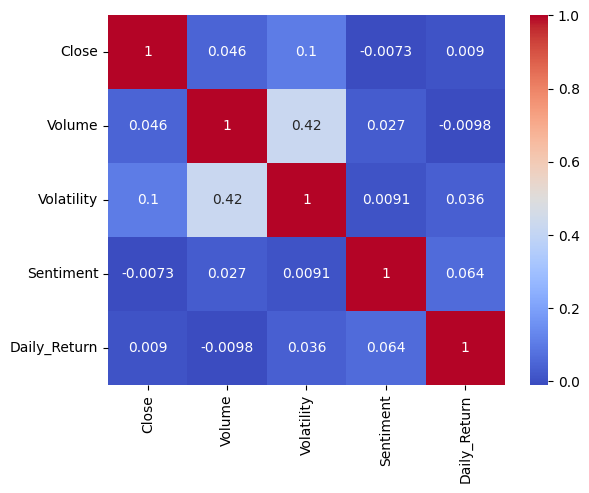

In [29]:
sns.heatmap(df[["Close","Volume","Volatility","Sentiment","Daily_Return"]].corr(), annot=True, cmap="coolwarm")
plt.show()

Next, we will engineer some features that might help simplify the inputs to our model

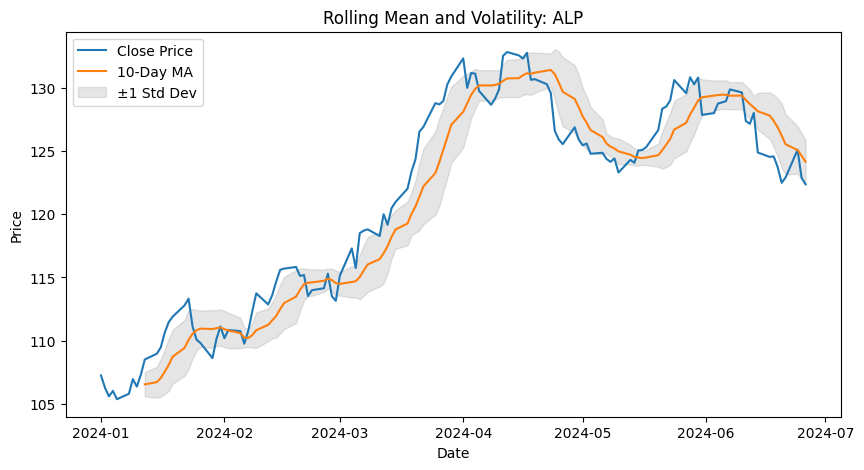

In [ ]:
window = 10
df["Rolling_Mean"] = df.groupby("Stock")["Close"].transform(lambda x: x.rolling(window).mean())
df["Rolling_Std"] = df.groupby("Stock")["Close"].transform(lambda x: x.rolling(window).std())
df["Target_Return"] = df.groupby("Stock")["Daily_Return"].shift(-1)
df = df.dropna(subset=["Target_Return"])

Lets try plotting our new features

In [ ]:
plt.figure(figsize=(10,5))
sample_stock = df["Stock"].iloc[0]
subset = df[df["Stock"] == sample_stock]
plt.plot(subset["Date"], subset["Close"], label="Close Price")
plt.plot(subset["Date"], subset["Rolling_Mean"], label=f"{window}-Day MA")
plt.fill_between(subset["Date"],
                 subset["Rolling_Mean"] - subset["Rolling_Std"],
                 subset["Rolling_Mean"] + subset["Rolling_Std"],
                 color='gray', alpha=0.2, label="±1 Std Dev")
plt.title(f"Rolling Mean and Volatility: {sample_stock}")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [ ]:





# --- 9. Rolling Statistics ---
window = 10
df["Rolling_Mean"] = df.groupby("Stock")["Close"].transform(lambda x: x.rolling(window).mean())
df["Rolling_Std"] = df.groupby("Stock")["Close"].transform(lambda x: x.rolling(window).std())

plt.figure(figsize=(10,5))
sample_stock = df["Stock"].iloc[0]
subset = df[df["Stock"] == sample_stock]
plt.plot(subset["Date"], subset["Close"], label="Close Price")
plt.plot(subset["Date"], subset["Rolling_Mean"], label=f"{window}-Day MA")
plt.fill_between(subset["Date"],
                 subset["Rolling_Mean"] - subset["Rolling_Std"],
                 subset["Rolling_Mean"] + subset["Rolling_Std"],
                 color='gray', alpha=0.2, label="±1 Std Dev")
plt.title(f"Rolling Mean and Volatility: {sample_stock}")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

# --- 10. Simple Trading Signal Example ---
# Buy when sentiment > 0.3, Sell when sentiment < -0.3
df["Signal"] = np.where(df["Sentiment"] > 0.3, "Buy",
                np.where(df["Sentiment"] < -0.3, "Sell", "Hold"))

print("\n--- Sample Trading Signals ---")
print(df[["Date","Stock","Close","Sentiment","Signal"]].head(15))

# --- 11. Save the Enriched Dataset ---
df.to_csv("enriched_stock_data.csv", index=False)
print("\n💾 Enriched dataset saved as 'enriched_stock_data.csv'!")


ValueError: could not convert string to float: 'ALP'